Consigna:

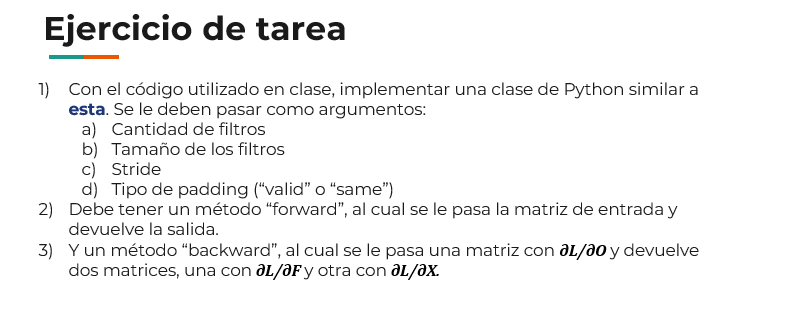

**Importo librerias**

In [40]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf

In [41]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
class Conv2d(object):
    
    def __init__(self, input_channels, kernels, kernel_size, stride, padding):
        self.stride = stride
        self.padding = padding
        self.kernel_size = kernel_size
        self.w = np.random.randn(kernels, input_channels, kernel_size, kernel_size)
        self.b = np.random.randn(kernels)
        self.last_output = None
        self.last_input = None
        
       
    # Función para padding con ceros

    def zero_padding(self, X):
          if self.padding == "valid":
              return X
          elif self.padding == "same":
              pad = ((self.stride -1) * X.shape[0] - self.stride + self.kernel_size)/2
              pad = int(pad)
              X_padded = np.pad(X, ((0,0), (0,0), (pad, pad), (pad, pad)), mode='constant', constant_values = (0,0))
              return X_padded, pad

    # Función para realizar la operación de convolución

    def convolve(self,X, W, b):
      """
      Argumentos:
        X: Array numpy de entrada con dimensiones (filter_size, filter_size, n_C_prev)
        W: Array numpy con los pesos de un filtro con dimensiones (filter_size, filter_size, n_C_prev)
        b: Entero con el valor de bias de la capa actual

      Retorna:
        Z: Entero con el valor del resultado
      """

      # Multiplico elemento a elemento el valor de entrada con los pesos del filtro
      aux = X * W
      # Realizo la suma de todos los elementos
      aux = np.sum(aux)
      # Le sumo el valor del bias para obtener Z
      Z = aux + float(b)

      return Z
    
    # Función para realizar el forward pass de una capa convolucional

    def conv_forward(self, layer_input):
        """
        Argumentos:
        layer_input: Array numpy con los valores de entrada a la capa convolucional (batch_size, n_C_prev, n_H_prev, n_W_prev) 

        Retorna:
        Z: Array numpy con los valores de salida de la capa convolucional (batch_size, n_H, n_W, n_C)
        """
        self.last_input = layer_input

        # Obtengo las dimensiones de la entrada
        (batch_size, n_C_prev, n_H_prev, n_W_prev) = self.last_input.shape

        # Obtengo las dimensiones de los filtros
        (n_C, n_C_prev, kernel_size, kernel_size) = self.w.shape
        
        # Agrego padding con ceros al volumen de entrada
        layer_input_padded, pad = self.zero_padding(self.last_input)
        
        n_H = int((n_H_prev + 2*pad - self.kernel_size)/self.stride + 1)
        n_W = int((n_W_prev + 2*pad - self.kernel_size)/self.stride + 1)
        
        # Inicializo el volumen de salida con ceros
        self.last_output = np.zeros([batch_size, n_C, n_H, n_W])

        # Comienzo iterando sobre cada ejemplo del batch
        for i in range(batch_size):
            
            # Itero sobre el eje vertical del volumen de salida
            for h in range(n_H):
                
                # Calculo las coordenadas verticales de inicio y fin de la ventana sobre la que aplicaremos el filtro
                y_start = self.stride * h
                y_end = y_start + kernel_size
                
                # Itero sobre el eje horizontal del volumen de salida
                for w in range(n_W):
                    
                    # Calculo las coordenadas horizontales de inicio y fin de la ventana sobre la que aplicaremos el filtro
                    x_start = self.stride * w
                    x_end = x_start + kernel_size

                    # Extraigo la ventana para calcular la convolucion, del volumen de entrada con padding
                    slice_from_input_padded = layer_input_padded[i, :, y_start:y_end, x_start:x_end]
        
                    # Itero sobre la cantidad de canales del volumen de salida
                    for c in range(n_C):
                        # Obtengo el valor del filtro y bias del canal correspondiente
                        kernel = self.w[c, :, :, :]
                        bias = self.b[c]

                    # Computo la operación de convolución para esta ventana
                        self.last_output[i, c, h, w] = self.convolve(slice_from_input_padded, kernel, bias)
  
        return self.last_output

    def backward(self, dl_do):
        
        #dimensiones de la derivada de L con respecto de O
        (batch_size, n_C, n_H, n_W) = dl_do.shape #OK

        #dimensiones de la entrada de la capa (output del forward)
        
        layer_output = self.conv_forward(self.last_input)#OK
        
        (batch_size, n_C_prev, n_H_prev, n_W_prev) = layer_output.shape#OK
        
        # Inicializo el volumen de salida con ceros
        self.last_output = np.zeros([batch_size, n_C, n_H, n_W])
        
    #    for c in (n_C):
     #       kernel = self.W[c,:,:,:]
            
            #giro 180 grados el kernel para convolucionar con la matriz de derivadas dL_dO
      #      conv_kernel = kernel.reshape(kernel.size)
       #     conv_kernel = conv_kernel[::-1]
        #    conv_kernel = conv_kernel.reshape(kernel.shape)
         #   dx = conv_kernel * dl_do
        # Comienzo iterando sobre numero de canales de entrada
        for n in (n_C):
  
          # Itero sobre el eje vertical del volumen de salida
            for h in range(n_H):
            # Calculo las coordenadas verticales de inicio y fin de la ventana sobre la que aplicaremos el filtro
              y_start = stride * h
              y_end = y_start + self.kernel_size
            # Itero sobre el eje horizontal del volumen de salida
            for w in range(n_W):
              # Calculo las coordenadas horizontales de inicio y fin de la ventana sobre la que aplicaremos el filtro
              x_start = stride * w
              x_end = x_start + self.kernel_size
              # Itero sobre la cantidad de canales del volumen de salida
              for c in range(n_C):
                aux = 0
                for i in range(batch_size):
                  # Extraigo la ventana para calcular la convolucion, del volumen de entrada con padding
                  slice_from_input_padded = dl_do[i, n, y_start:y_end, x_start:x_end]
                  # Obtengo el valor del filtro del canal correspondiente y bias 
                  kernel = self.w[c, :, :, :]
                  bias = self.b[c]
                  aux = aux + self.convolve(slice_from_input_padded, filter)
                
                # Computo la operación de convolución para esta ventana (media del batchsize)
                self.last_output[i, c, h, w] = self.convolve(slice_from_input_padded, kernel, bias)
        return self.last_output

    #    for c in (n_C):
     #       kernel = self.W[c,:,:,:]
            
      #      #giro 180 grados el kernel para convolucionar con la matriz de derivadas dL_dO
       #     conv_kernel = kernel.reshape(kernel.size)
        #    conv_kernel = conv_kernel[::-1]
         #   conv_kernel = conv_kernel.reshape(kernel.shape)
        
        
        
        #dx = conv_kernel * dl_do
        
        #return dx*/
    
    def convolve_back_df(self, dl_do, X):
        
        self.last_input = X
        df = X * dl_do

In [43]:
batch_size = 1
input_height, input_width = (6, 6)
input_channels = 1

# Dimensiones de la convolucional
filters = 8
filter_size = 3
stride = 1
pad = "same"

test_array = np.random.randn(batch_size, input_channels, input_height, input_width)

In [44]:
conv = Conv2d(input_channels, filters, filter_size, stride, pad)

In [45]:
x_paded, pad = conv.zero_padding(test_array)

**Padding**


In [46]:
batch_size = 1
input_height, input_width = (7, 7)
input_channels = 3
# Dimensiones de la convolucional
filters = 8
filter_size = 3
stride = 1
pad = "same"

test_array = np.random.randn(batch_size, input_channels, input_height, input_width)

In [47]:

conv = Conv2d(input_channels, filters, filter_size, stride, pad)

In [48]:

X_padded, pad = conv.zero_padding (test_array)

In [49]:
pad

1

In [50]:
X_padded.shape

(1, 3, 9, 9)


**Convolve**

In [51]:
import torch

In [52]:
conv_result = conv.conv_forward(test_array)
print("Convolución: Result shape: {}".format(conv_result.shape))
print("Convolución: Result value: {}".format(conv_result[0,0,0,0]))


Convolución: Result shape: (1, 8, 7, 7)
Convolución: Result value: 2.1441475958995726
